# Getting started

First we need to install some packages and download some files for Colab.

In [1]:
!apt-get -qq install -y graphviz && pip install pydot
!pip install -U matplotlib
!pip install git+https://github.com/fastmachinelearning/hls4ml.git@main#egg=hls4ml[profiling]
!pip install qkeras==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fastmachinelearning/hls4ml.git (to revision main) to /tmp/pip-install-iguu1u4d/hls4ml_ce5db38e7d8840f3a8b8a56246db51b8
  Running command git clone -q https://github.com/fastmachinelearning/hls4ml.git /tmp/pip-install-iguu1u4d/hls4ml_ce5db38e7d8840f3a8b8a56246db51b8
  Running command git submodule update --init --recursive -q
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
# import os
# os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
# for this tutorial we wont be actually running Vivado, so I have commented these lines out
#     but if you want to look into actually running on an FPGA then simply uncomment these lines

## Fetch the jet tagging dataset from Open ML

In [3]:
data = fetch_openml("hls4ml_lhc_jets_hlf")
X, y = data["data"], data["target"]

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [4]:
print(data["feature_names"])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you see above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc. These correspond to different source particles for the jets. You will notice that except for quark- and gluon-initiated jets ('g'), all other jets in the dataset have at least one 'prong'. 
<img src="jet_classes.png" alt="jet_classes" width="600"/>

### Lets see what the jet variables look like

Many of these variables are energy correlation functions $N$, $M$, $C$, and $D$ ([1305.0007](https://arxiv.org/pdf/1305.0007.pdf), [1609.07483](https://arxiv.org/pdf/1609.07483.pdf)). The others are the jet mass (computed with modified mass drop) $m_\textrm{mMDT}$, $\Sigma~z\log z$ where the sum is over the particles in the jet and $z$ is the fraction of jet momentum carried by a given particle, and the overall multiplicity of particles in the jet.

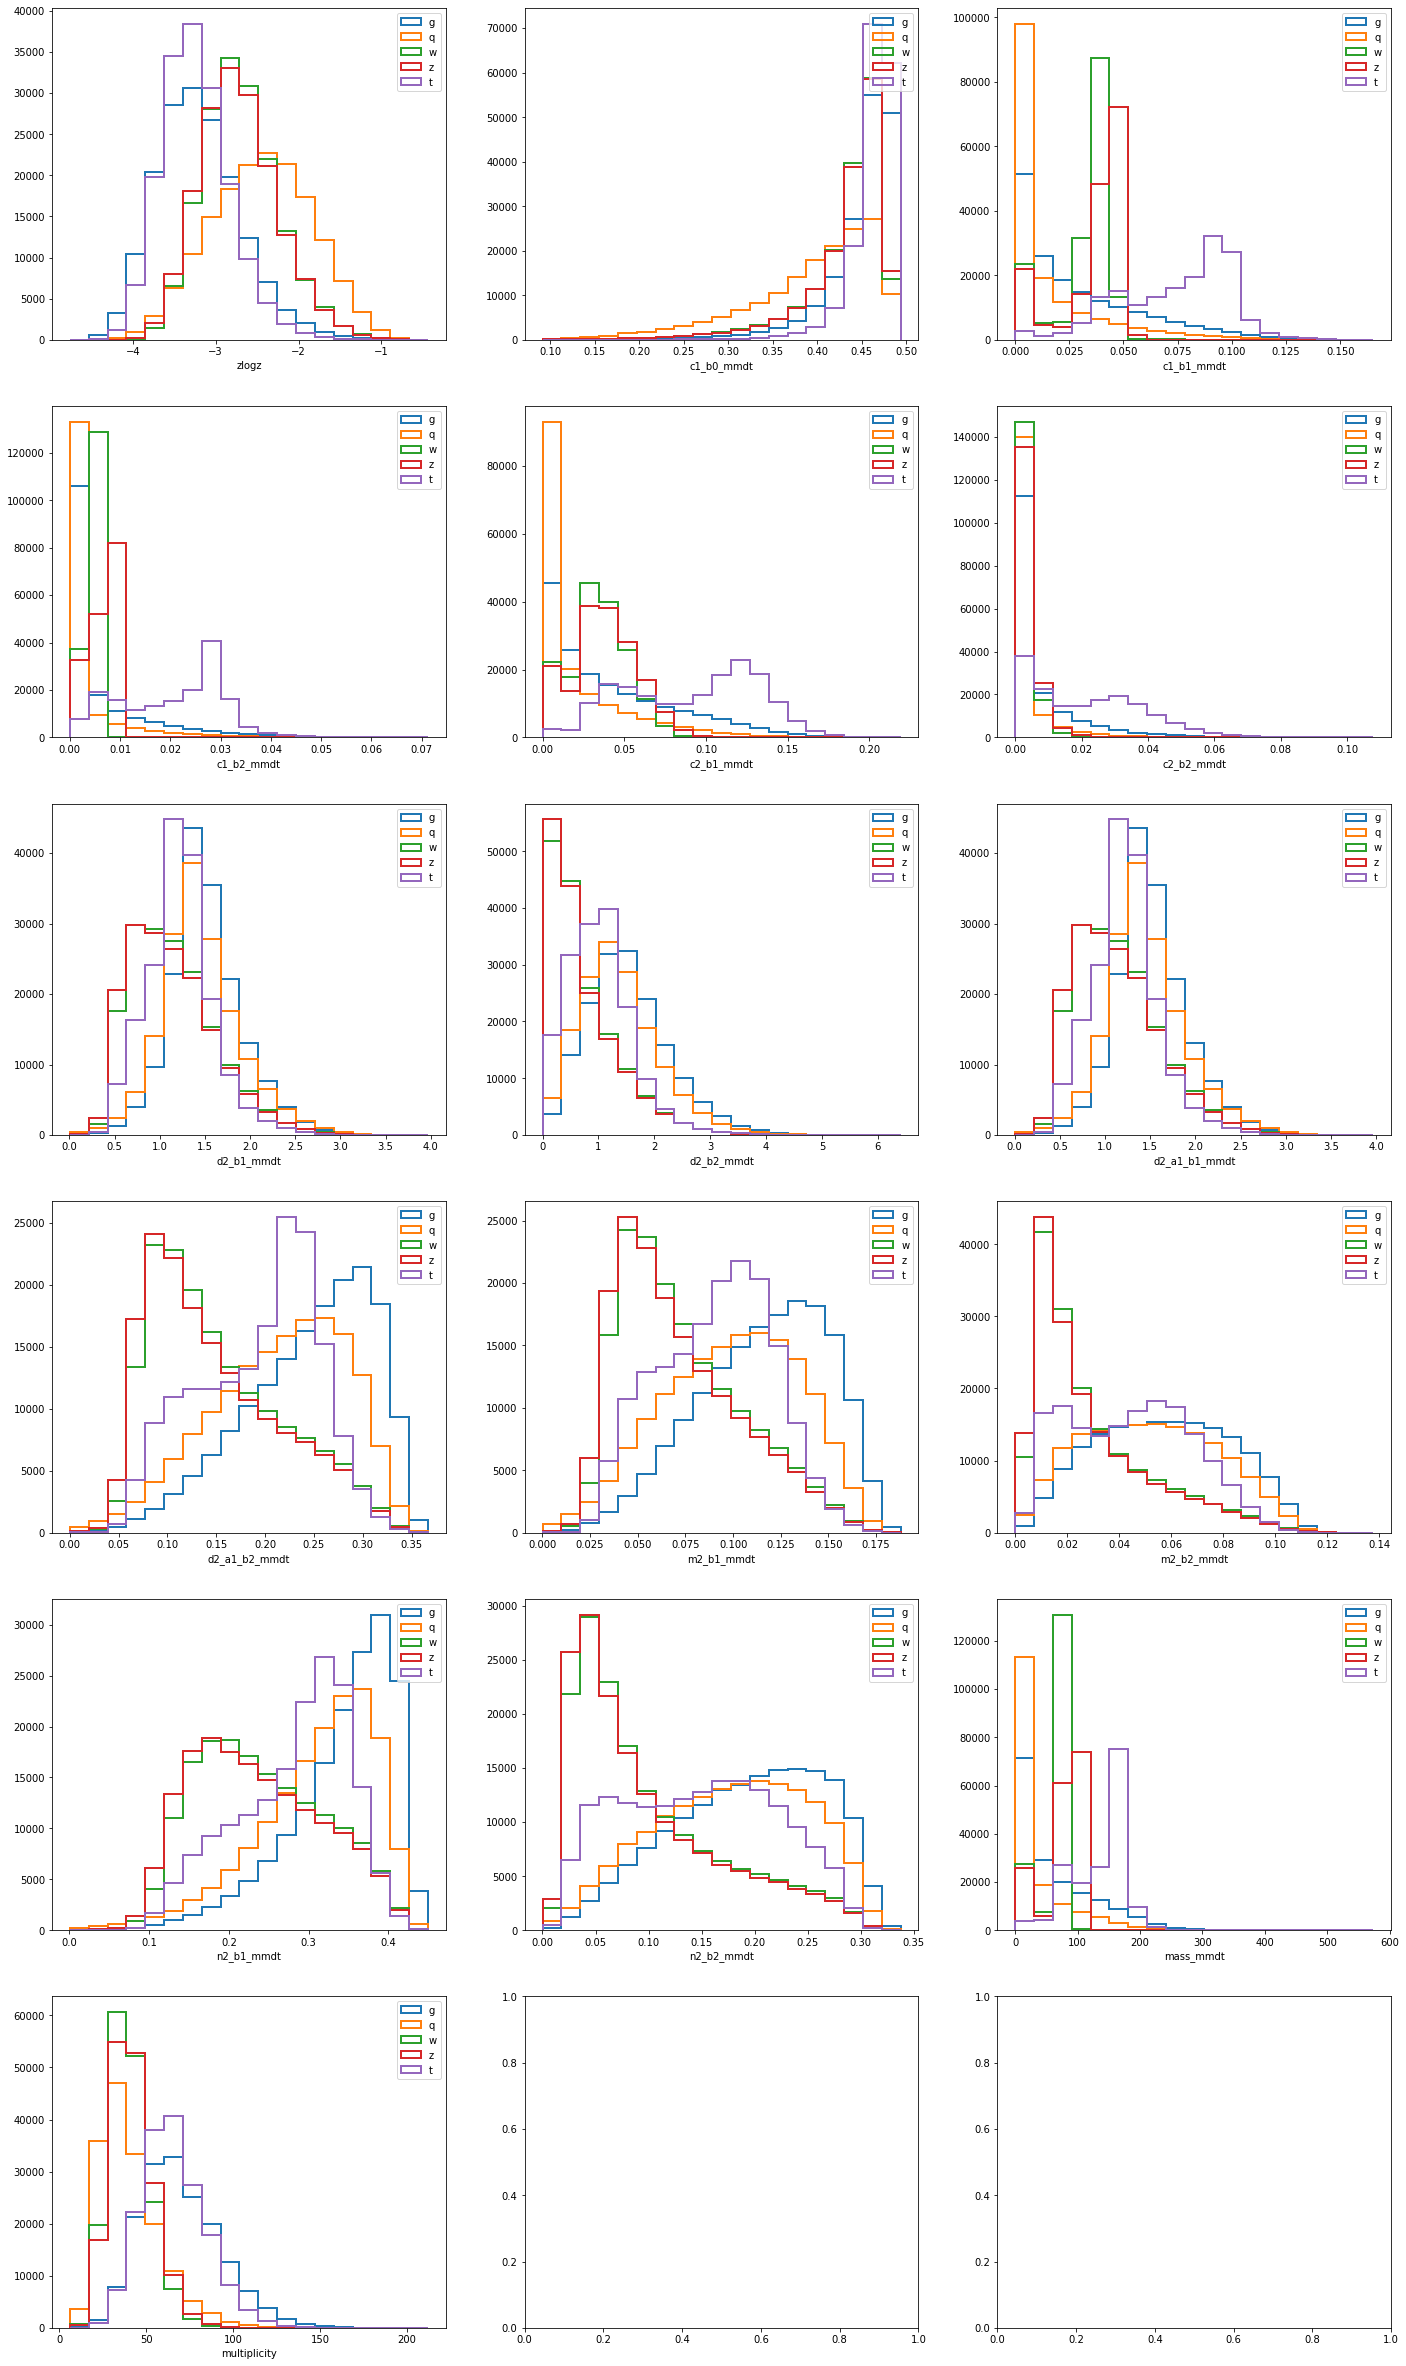

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    int(np.ceil(len(data["feature_names"]) / 3)),
    3,
    figsize=(8 * 3, 8 * len(data["feature_names"]) / 3),
)

for feat in data["feature_names"]:
    for c in ["g", "q", "w", "z", "t"]:
        X[y == c][feat]

ix = 0
for ax1 in axs:
    for ax in ax1:
        feat = data["feature_names"][ix]
        bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 20)
        for c in ["g", "q", "w", "z", "t"]:
            X[y == c][feat]
            ax.hist(
                X[y == c][feat], bins=bins, histtype="step", label=c, lw=2
            )  # ,density=True)
            ax.set_xlabel(feat)
        ax.legend()
        ix = ix + 1
        if ix >= len(data["feature_names"]):
            break

plt.show()

Because the `y` target is an array of strings, e.g. \['g', 'w',...\], we need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [7]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

We now save the datasets as raw numpy arrays so that we can restart later without redownloading the dataset and converting.

In [8]:
np.save("X_train_val.npy", X_train_val)
np.save("X_test.npy", X_test)
np.save("y_train_val.npy", y_train_val)
np.save("y_test.npy", y_test)
np.save("classes.npy", le.classes_)
classes = le.classes_

## Now construct a simple neural network
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [10]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name="fc1", kernel_initializer="lecun_uniform"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2", kernel_initializer="lecun_uniform"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3", kernel_initializer="lecun_uniform"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="output", kernel_initializer="lecun_uniform"))
model.add(Activation(activation="softmax", name="softmax"))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [11]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(
        optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"]
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir="model_1",
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model("model_1/KERAS_check_best_model.h5")

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


483/487 [============================>.] - ETA: 0s - loss: 1.2665 - accuracy: 0.5154
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 1.06039, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.06039, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 5ms/step - loss: 1.2650 - accuracy: 0.5163 - val_loss: 1.0604 - val_accuracy: 0.6376 - lr: 1.0000e-04
Epoch 2/30
483/487 [============================>.] - ETA: 0s - loss: 0.9903 - accuracy: 0.6676
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 1.06039 to 0.94141, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.06039 to 0.94141, saving model to model_1/KERAS_check_best_model_weights.

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7516927710843373


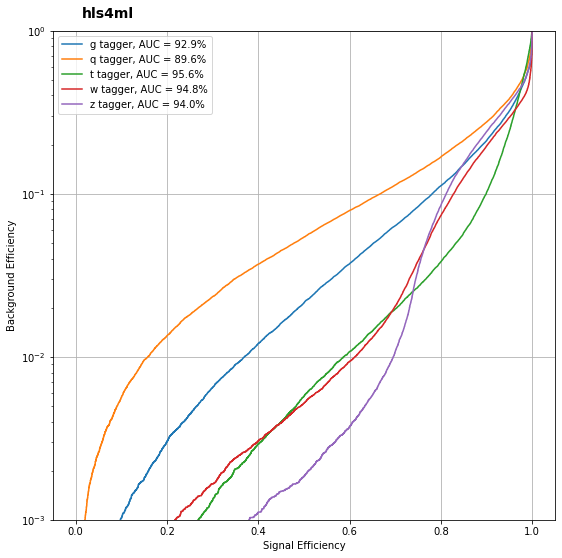

In [12]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print(
    "Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))
    )
)
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

# Convert the model to an hls4ml project
Now we will go through the steps to convert the model we trained to an hls4ml project.
With High Level Synthesis (HLS) tools this project can be synthesized into FPGA firmware.
For this tutorial we will use hls4ml to explore the possibilities for quantized and pruned implementations of our neural network.

With a Vivado HLS installation we could also synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

## Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation.
The `part` argument denotes the target FPGA for the project, but this will not matter for our purposes.

In [13]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity="model")
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir="model_1/hls4ml_prj",
    part="xcu250-figd2104-2L-e",
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Configuration
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activat

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

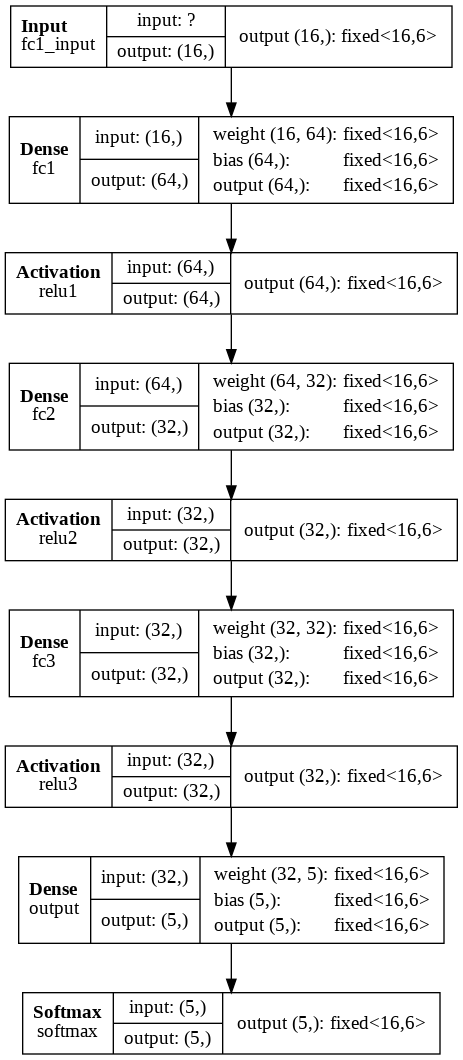

In [14]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Precision

All the numbers we use in the hls4ml models will be in what is called fixed-point encoding. Traditional floating point numbers that you are likely more used to are encoded using the scheme shown below. 
<img src="https://raw.githubusercontent.com/drankincms/iaifi-summer-school/main/book/floating_point_encoding.png" alt="floating_point" width="800"/>
This provides a wide range of possible values and fine granularity.

However, using this many bits can be excessive, and in the case of running algorithms on FPGAs or other similar devices, requires substantial overhead. Instead, what is typically used is a flexible fixed-point encoding scheme, shown below.
<img src="https://raw.githubusercontent.com/drankincms/iaifi-summer-school/main/book/fixed_point_encoding.png" alt="fixed_point" width="400"/>
In this case the integer component and the fractional component of the number of separated and a fixed number of bits are used to encode each part. The `ap_fixed<width,integer>` notation is specific to Vivado HLS (and hls4ml), but the concept of fixed-point encoding is general.

## Compile, predict
Now that we have the hls4ml model we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the fixed-point model.

In [15]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7516927710843373
hls4ml Accuracy: 0.7513975903614458


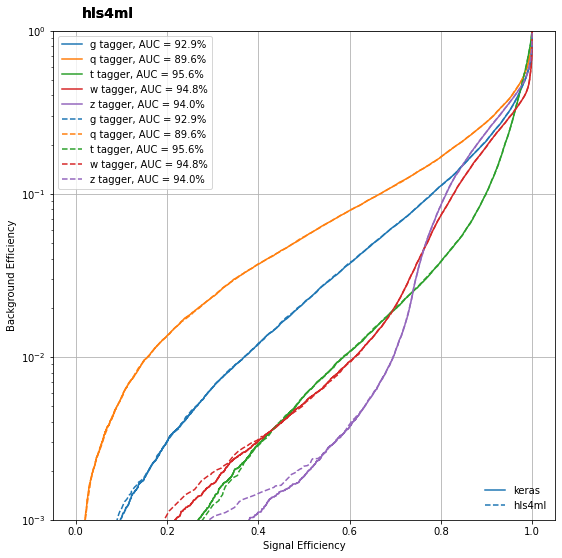

In [16]:
print(
    "Keras  Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))
    )
)
print(
    "hls4ml Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle="--")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=["keras", "hls4ml"], loc="lower right", frameon=False)
ax.add_artist(leg)

In [17]:
_, _, aucs_keras = plotting.rocData(y_test, y_keras, le.classes_)
_, _, aucs_hls = plotting.rocData(y_test, y_hls, le.classes_)
print("Keras: ", aucs_keras)
print("HLS:   ", aucs_hls)
print("Ratio: ", {p: aucs_hls[p] / aucs_keras[p] for p in aucs_hls})

Keras:  {'g': 0.9290278992113158, 'q': 0.8958955049291232, 't': 0.9558102774019699, 'w': 0.94839345251029, 'z': 0.9404662196107185}
HLS:    {'g': 0.9289441521785633, 'q': 0.8957866614035521, 't': 0.9557294362569719, 'w': 0.9483799543021966, 'z': 0.9402268294669953}
Ratio:  {'g': 0.9999098552015245, 'q': 0.9998785086821262, 't': 0.9999154213478247, 'w': 0.9999857672909301, 'z': 0.9997454558826979}


## AUC information
Now that we know how to extract the AUCs and compare the floating point and fixed point values, lets look at how we could determine a good choice for the number of bits to use for this model.

We will fix the number of integer bits to 6 and scan the fractional bits used for the model, and then compare the AUCs in each case. This requires re-compiling the hls4ml project for each fixed-point type we are curious about, and can take a bit of time.

In [18]:
auc_ratios = {}
ib_opts = range(6, 7)
fb_opts = range(4, 15)
for int_bits in ib_opts:
    for frac_bits in fb_opts:
        prec = "%i,%i" % (int_bits + frac_bits, int_bits)
        print("Precision: ", prec)
        config = hls4ml.utils.config_from_keras_model(
            model, granularity="model", default_precision="ap_fixed<%s>" % prec
        )
        hls_model = hls4ml.converters.convert_from_keras_model(
            model,
            hls_config=config,
            output_dir="model_1/hls4ml_prj",
            part="xcu250-figd2104-2L-e",
        )
        hls_model.compile()
        y_hls = hls_model.predict(X_test)
        _, _, aucs_hls = plotting.rocData(y_test, y_hls, le.classes_)
        auc_ratios[prec] = {p: aucs_hls[p] / aucs_keras[p] for p in aucs_hls}
print(auc_ratios)

Precision:  10,6
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu

In [19]:
auc_ratios_grid = {}
for c in le.classes_:
    auc_array = []
    for int_bits in ib_opts:
        int_array = []
        for frac_bits in fb_opts:
            int_array.append(auc_ratios["%i,%i" % (int_bits + frac_bits, int_bits)][c])
        auc_array.append(int_array)
    auc_ratios_grid[c] = np.array(auc_array)
avg = np.sum(np.array([auc_ratios_grid[c] for c in le.classes_]), axis=0) / len(
    le.classes_
)
auc_ratios_grid["Average"] = avg
print(auc_ratios_grid["w"])
print(auc_ratios_grid["Average"])

[[0.56754164 0.79653717 0.98010885 0.99660763 0.99938435 0.99981275
  0.99998577 0.9999416  0.99994328 0.99991328 0.99991487]]
[[0.64020089 0.87584443 0.98353028 0.99598378 0.99891285 0.99967432
  0.999887   0.99991505 0.99991954 0.99990799 0.99990119]]


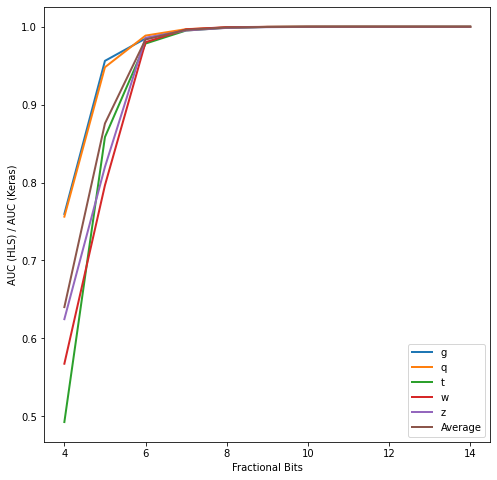

In [20]:
plt.figure(figsize=(8, 8))
for c in auc_ratios_grid:
    plt.plot(fb_opts, auc_ratios_grid[c][0], label=c, lw=2)
plt.ylabel("AUC (HLS) / AUC (Keras)")
plt.xlabel("Fractional Bits")
plt.legend()

We can see that when the number of fractional bits is above 8 the fixed-point model recovers the full floating-point performance (as measured by the AUC). Performance of the fixed-point model really suffers when the number of fractional bits is less than 6.